<a href="https://colab.research.google.com/github/Jaew00/DeepLearning/blob/main/%5B%EC%8B%A4%EC%8A%B505%5D_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Settings

> 1) Important required libraries




In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils
%matplotlib inline

2) Hyperparameter

In [2]:
batch_size = 16
learning_rate = 0.0001
epoch = 20

n_node = 1024
dropratio = 0.5
imgsize = 256

2. Data Loader

트레이닝 데이터

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
img_dir = "/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/animal+utils/animal/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
              transforms.CenterCrop(imgsize*2),
              transforms.RandomCrop(imgsize),
              transforms.RandomHorizontalFlip(),
              transforms.Resize(imgsize),
              transforms.ToTensor()
              ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size,
                              shuffle = True, num_workers=2)

46


고정된 데이터 셋

In [5]:
# 2. Dev data
img_dir = "/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/animal+utils/animal/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
              #transforms.Scale(256),
              #transform.RandomSizedCrop(224),                                           
              transforms.CenterCrop(imgsize),

              transforms.Resize(imgsize),
              transforms.ToTensor()
              ]))


dev_batch = data.DataLoader(dev_data, batch_size = batch_size,
                              shuffle = False, num_workers=2)

In [6]:
# Test data
img_dir = "/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/animal+utils/animal/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
              #transforms.Scale(256),
              #transform.RandomSizedCrop(224),                                           
              transforms.CenterCrop(imgsize),

              transforms.Resize(imgsize),
              transforms.ToTensor()
              ]))


test_batch = data.DataLoader(test_data, batch_size = batch_size,
                              shuffle = False, num_workers=2)

In [7]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" %(train_data.__len__(), dev_data.__len__(),test_data.__len__()))

# of classes: 2
['cats', 'dogs']
{'cats': 0, 'dogs': 1}
46
Training: 46, Dev: 17, Test: 41


In [8]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cats', 'dogs']
['cats', 'dogs']
['cats', 'dogs']


3. Model


> 1) Pretrained VGG Model



In [9]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children() :
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])
print(list(vgg.children())[0][0])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

2) Customized Fully Model

In [10]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module) :
  def __init__(self) :
    super(MyVGG, self).__init__()
    self.layer0 = nn.Sequential(*list(vgg.children())[0])

    self.layer1 = nn.Sequential(
        nn.Linear(8 * base_dim * fsize * fsize, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, nclass),   
    )

    for m in self.layer1.modules() :
      if isinstance(m, nn.Conv2d) :
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear) :
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)

  def forward(self, x) :
    out = self.layer0(x)
    out = out.view(out.size(0), -1)
    out = self.layer1(out)

    return out

3) Model on GPU

In [11]:
model = MyVGG().cuda()

for params in model.layer0.parameters() :
  params.required_grad = False

for params in model.layer1.parameters() :
  params.required_grad = True

for name in model.children() :
  print(name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

4. Optimizer & Loss

In [12]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

# import itertools
#optimizer = optim.Adam(itertool.chain(model.layer1.parameters(), model.layer2.parameters()), lr=learning_rate)

5. Train

In [13]:
import utils
total_time = 0
disp_step = 10

to_train = True
if(to_train == False) :
  netname = '/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/animal+utils/animal/weights/catdog_vgg19.pkl'
  model = torch.load(netname)
else :
  print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
  model.eval()
  train_corr = utils.ComputeCorr(train_batch, model)
  dev_corr = utils.ComputeCorr(dev_batch, model)
  test_corr = utils.ComputeCorr(test_batch, model)
  print("Correct of train: %.2f, dev : %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
  model.train()

  netname = '/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/weights/'

  x_epoch = []
  y_train_err = []
  y_dev_err = []
  y_test_err = []

  x_epoch.append(0)
  y_train_err.append(100.0 - train_corr)
  y_dev_err.append(100.0 - dev_corr)
  y_test_err.append(100.0 - test_corr)

  # 학습을 재시작한다면
  #netname = '/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/animal+utils/animal/weights/catdog_vgg19.pkl'
  #model = torch.load(netname)
  #파라미터 학습 여부 결정
  #for params in model.layer0.parameters() :
  # params.required_grad = False
  #for params in model.layer1.parameters() :
  # params.required_grad = True
  #for i in range(34, epoch) :

  # 재시작하지 않는 다면
  for i in range(epoch) :
    start_time = time.time()
    print("%d.." %i),
    for img, label in train_batch :
      img = Variable(img).cuda()
      label = Variable(label).cuda()

      optimizer.zero_grad()
      output = model(img)
      loss = loss_func(output, label)
      loss.backward()
      optimizer.step()

      end_time = time.time()
      duration = end_time - start_time
      total_time += duration

      if(i % disp_step == 0) or (i == epoch - 1) :
        torch.save(model, netname+'_%d.pkl'%i, )
        print("\n[%d/%d] loss : %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),

        model.eval()

        train_corr = utils.ComputeCorr(train_batch, model)
        dev_corr = utils.ComputeCorr(dev_batch, model)
        test_corr = utils.ComputeCorr(test_batch, model)

        print("Correct of train: %.2f, dev : %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
        model.train()
        print("time: %.2f sec ..." %(total_time))

        x_epoch.append(i+1)
        y_train_err.append(100.0 - train_corr)
        y_dev_err.append(100.0 - dev_corr)
        y_test_err.append(100.0 - test_corr)
  print("Total time: %.2f sec" %total_time)


3 layer, n_node: 1024, dropratio: 0.50


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Correct of train: 52.17, dev : 47.06, test: 63.41
0..

[0/20] loss : 0.727, 
Correct of train: 50.00, dev : 52.94, test: 70.73
time: 0.27 sec ...

[0/20] loss : 0.788, 
Correct of train: 54.35, dev : 47.06, test: 63.41
time: 3.21 sec ...

[0/20] loss : 0.912, 
Correct of train: 58.70, dev : 52.94, test: 68.29
time: 8.74 sec ...
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss : 0.679, 
Correct of train: 89.13, dev : 70.59, test: 90.24
time: 25.31 sec ...

[10/20] loss : 0.480, 
Correct of train: 78.26, dev : 70.59, test: 90.24
time: 28.33 sec ...

[10/20] loss : 0.776, 
Correct of train: 86.96, dev : 64.71, test: 82.93
time: 33.93 sec ...
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss : 0.897, 
Correct of train: 84.78, dev : 70.59, test: 92.68
time: 48.64 sec ...

[19/20] loss : 0.503, 
Correct of train: 80.43, dev : 70.59, test: 92.68
time: 51.83 sec ...

[19/20] loss : 0.666, 
Correct of train: 86.96, dev : 70.59, test: 92.68
time: 57.73 sec ...
Total time: 57.73 se

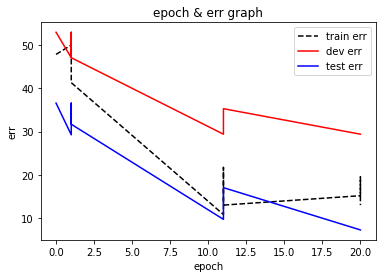

In [14]:
if (to_train) :
  plt.plot(x_epoch, y_train_err, color = 'black', label = 'train err', linestyle = '--')
  plt.plot(x_epoch, y_dev_err, color = 'red', label = 'dev err')
  plt.plot(x_epoch, y_test_err, color = 'blue', label = 'test err')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epoch & err graph')
  plt.legend(loc = 'upper right')
  plt.show()

6. Evaluation for dev & test data

/content/utils.py:105: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(imgs, volatile=True).cuda()  ## back prop. 안하고, forward prop. 만 하겠다.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


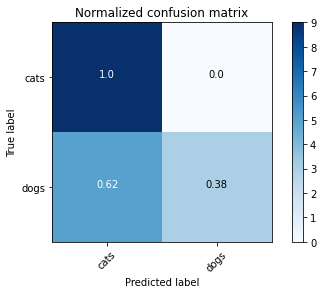

Confusion matrix, without normalization


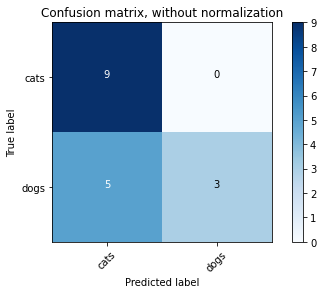

	 acc  |	 pre  |	 rec  |	 f1
 cats: 0.71 |	 0.64 |	 1.00 |	 0.78
 dogs: 0.71 |	 1.00 |	 0.38 |	 0.55
*accuracy: 0.71, precision: 0.82, recall: 0.69, *f1 score: 0.66
[AP]
cats: 0.81
dogs: 0.80

[mAP] 0.803
[miAP] 0.853


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.51606256, 0.94207823, 0.73740375, 0.53477252, 0.86908132,
        0.60346812, 0.60694635, 0.96670872, 0.62396491, 0.50113291,
        0.60471338, 0.85694027, 0.6244579 , 0.6567381 , 0.77174008,
        0.93215144, 0.63447547]))

In [15]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

/content/utils.py:105: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(imgs, volatile=True).cuda()  ## back prop. 안하고, forward prop. 만 하겠다.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


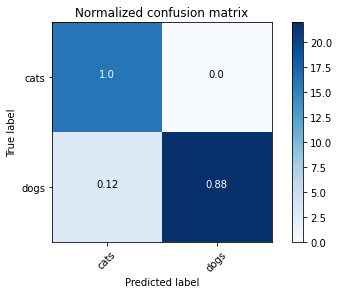

Confusion matrix, without normalization


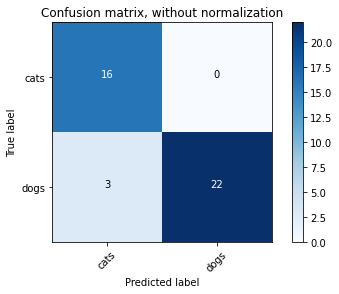

	 acc  |	 pre  |	 rec  |	 f1
 cats: 0.93 |	 0.84 |	 1.00 |	 0.91
 dogs: 0.93 |	 1.00 |	 0.88 |	 0.94
*accuracy: 0.93, precision: 0.92, recall: 0.94, *f1 score: 0.93
[AP]
cats: 1.00
dogs: 1.00

[mAP] 1.000
[miAP] 0.963


In [16]:
model.eval()
_, _, _ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Category: cats
 True predicted images/total cats category: 9 / 9
Predicted probability:
[0.51606256 0.4839374 ]


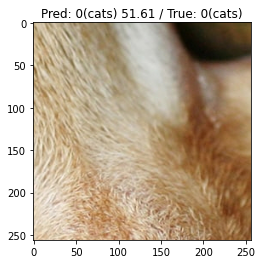

Predicted probability:
[0.94207823 0.05792176]


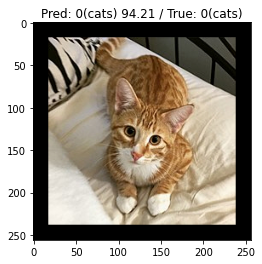

 False predicted images/total cats category: 0 / 9
Category: dogs
 True predicted images/total dogs category: 3 / 8
Predicted probability:
[0.1430597  0.85694027]


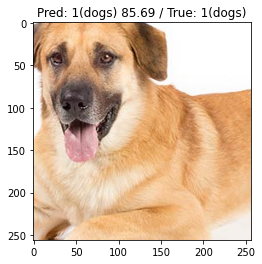

Predicted probability:
[0.22825994 0.7717401 ]


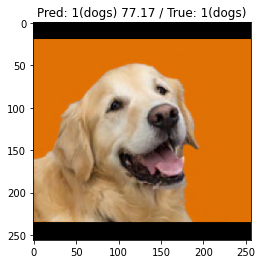

 False predicted images/total dogs category: 5 / 8
Predicted probability:
[0.5011329 0.4988671]


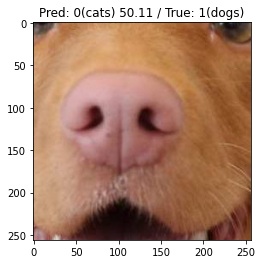

Predicted probability:
[0.6047134  0.39528662]


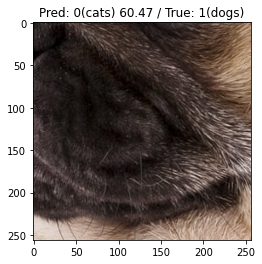

In [17]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n = 2)